In [1]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as trns
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from tqdm import tqdm, trange
import sys
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import copy

folder = 'visualize'
try:
    os.mkdir(folder)
except:
    print(folder+' folder already exist')

class_name = {'good':0,'none':1,'bad':2}


In [2]:

class maskDataset(Dataset):
    def __init__(self,usage):
        print('load %s dataset'%usage)
        self.df = pd.read_csv(usage+'_crop.csv')
        self.folder = 'img2%s/'%usage
        self.transform = trns.Compose([trns.ToTensor()])
        
    def __getitem__(self,index):
        img = Image.open(self.folder+self.df['file'][index]).convert('RGB')
        img = self.transform(img)
        label = class_name[self.df['label'][index]]
        
        return img, label
    
    def __len__(self):
        return len(self.df.index)
        

In [3]:
batch_size = 8

train_set = maskDataset('train')
test_set = maskDataset('test')

train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(dataset=test_set,
                          batch_size=batch_size, 
                          shuffle=False,
                          num_workers=4)


load train dataset
load test dataset


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 17 * 17, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
def evaluation(model,dataloader):
    model.eval()
    error = 0
    total = len(dataloader.dataset)
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = net(imgs)
        y_hat = np.argmax(outputs.cpu().detach().numpy(),axis=1)
        y = labels.cpu().detach().numpy()
        error += np.count_nonzero(y-y_hat)
    model.train()
    return (1-(error/total))

    

In [6]:
learning_rate = 0.001
epoch = 60

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

iteration = 0
loss_log = 0
losses = []
train_accuracy = []
test_accuracy = []
# evaluate train
train_accuracy.append(evaluation(net,train_loader))

# evaluate test
test_accuracy.append(evaluation(net,test_loader))

t = trange(epoch)

for e in t:  # loop over the dataset multiple times
    i = 0
    
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        iteration += 1
        i += 1
        loss_log += loss.item()
        
    # calculate loss
    losses.append(loss_log/i)
    i = 0
    loss_log = 0
    
    # evaluate train
    train_accuracy.append(evaluation(net,train_loader))
    
    # evaluate test
    test_accuracy.append(evaluation(net,test_loader))
    
    t.set_description("training loss:%.4f, train accuracy:%.4f, test accuracy:%.4f"%(losses[-1],train_accuracy[-1],test_accuracy[-1]))

torch.save(net,'mask_detection.pkl')

training loss:0.0000, train accuracy:1.0000, test accuracy:0.9340: 100%|██████████| 60/60 [02:21<00:00,  2.37s/it]
/home/ray/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ray/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ray/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ray/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Lin

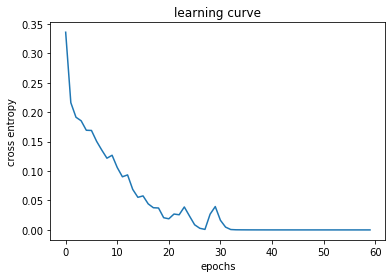

In [7]:
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('learning curve')
plt.plot(losses)
plt.savefig(folder+'/learning_curve.png', bbox_inches = "tight")
plt.show()


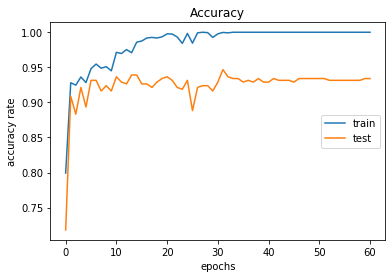

In [8]:
plt.xlabel('epochs')
plt.ylabel('accuracy rate')
plt.title('Accuracy')
plt.plot(train_accuracy,label='train')
plt.plot(test_accuracy,label='test')
plt.legend(loc='center right')
plt.savefig(folder+'/accuracy.png', bbox_inches = "tight")
plt.show()


In [10]:
def draw_box(img,df,label,path):
    mask = ['good','none','bad']
    for i,idx in enumerate(df.index):
        stat = mask[label[i]]
        xmin = df['xmin'][idx]
        xmax = df['xmax'][idx]
        ymin = df['ymin'][idx]
        ymax = df['ymax'][idx]
        
        if stat=='good':
            color = (0,255,0)
        elif stat=='none':
            color = (229, 207, 37)
        elif stat=='bad':
            color = (255,0,0)
            
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), color, 4)
        cv2.putText(img, stat, (xmin,ymin-10), cv2.FONT_HERSHEY_PLAIN, 2, color, 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.show()
    cv2.imwrite(path+'.jpg',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
def visualize(model,img,df,name):
    resize_img = []
    transform = trns.Compose([trns.ToTensor()])
    label = []
    for i in df.index:
        xmin = df['xmin'][i]
        xmax = df['xmax'][i]
        ymin = df['ymin'][i]
        ymax = df['ymax'][i]
        label.append(class_name[df['label'][i]])
        croped = img[ymin:ymax,xmin:xmax,:]
        resized = cv2.resize(croped,(80,80))
        resized = transform(resized)
        resize_img.append(resized)
    images = torch.stack(resize_img).cuda()
    output = model(images).cpu().detach().numpy()
    
    draw_box(copy.deepcopy(img),df,np.argmax(output,1),name+'_output')
    draw_box(copy.deepcopy(img),df,label,name+'_label')
        

visualize folder already exist


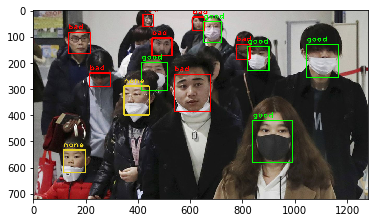

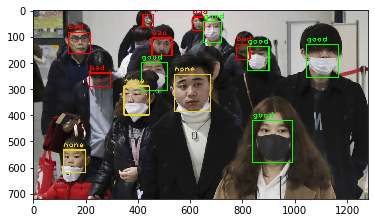

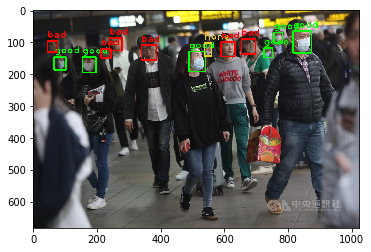

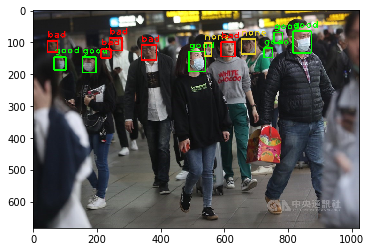

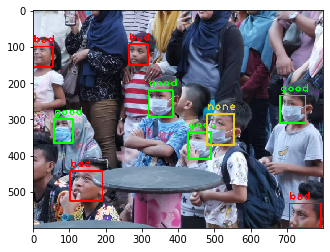

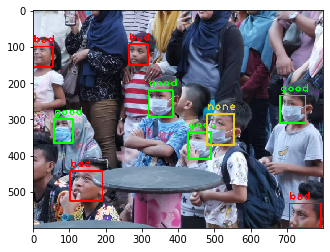

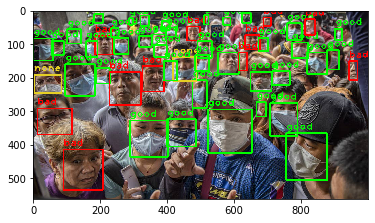

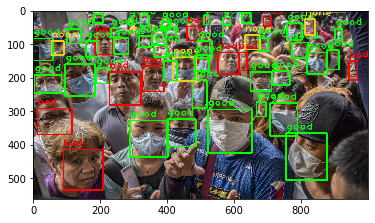

In [12]:
net.eval()
visual_df = pd.read_csv('test.csv')

idx_list = [0,100,200,300]
for i in idx_list:
    img_name = visual_df['filename'][i]
    img = Image.open('images/'+img_name).convert('RGB')
    img = np.array(img)
    img_df = visual_df.loc[visual_df['filename'] == img_name]

    visualize(net,img,img_df,folder+'/visual_%d'%i)



In [30]:
def class_accuracy(dataloader):
    accu = [0,0,0]
    total = [0,0,0]

    for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = net(imgs).cpu().detach().numpy()
            for c,l in zip(outputs,labels):
                total[l] += 1
                c = np.argmax(c)
                if c == l:
                    accu[l] += 1
    accu_rate = [a/t for a,t in zip(accu,total)]
    return accu_rate

train_acc = class_accuracy(train_loader)
test_acc = class_accuracy(test_loader)
print('class: good none bad')
print('train acc:',train_acc)
print('test acc:',test_acc)



class: good none bad
train acc: [1.0, 1.0, 1.0]
test acc: [0.9646643109540636, 0.5454545454545454, 0.9325842696629213]
